In [33]:
%cd /home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR/reviews

/home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR/reviews


In [80]:
import xarray as xr 
import cmipaccess as cmip
import numpy as np

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmip.preprocessing import correct_lon
import pandas as pd
from scipy.optimize import curve_fit
plt.style.use('robin')
import cartopy.feature as cfeat

from matplotlib.font_manager import fontManager
fontManager.addfont('../Arial.ttf')
fontManager.addfont('../Arial-bold.ttf')
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['mathtext.fontset'] = 'dejavuserif'


pica = 1/6
small_fig = 19*pica
med1_fig = 27*pica
med2_fig = 33*pica
large_fig = 39*pica

In [2]:
from dask.distributed import Client
client = Client(n_workers=10)

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:40659
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45125'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45913'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42001'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34903'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41361'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34007'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:32893'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40617'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46237'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36101'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:32777', name: 0, status: init, memor

# Why high latitude patterns are negative

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(


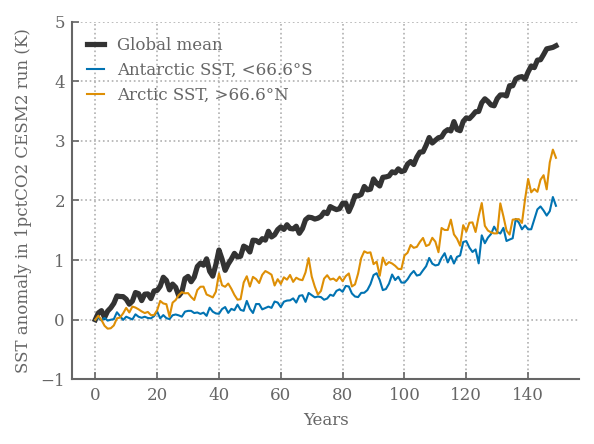

In [3]:
tos = xr.open_mfdataset(cmip.spiritx.get_path_CMIP_data('CESM2','1pctCO2', 'r1i1p1f1','tos',grid='gr'), chunks = dict(time=120)).tos.resample(time='YS').mean().assign_coords(time=np.arange(150))

tos_antarctic = tos.sel(lat=slice(-90,-66.6)).weighted(np.cos(np.deg2rad(tos.lat))).mean(['lon','lat']).load()
tos_arctic = tos.sel(lat=slice(66.6,90)).weighted(np.cos(np.deg2rad(tos.lat))).mean(['lon','lat']).load()
tos_global = tos.weighted(np.cos(np.deg2rad(tos.lat))).mean(['lon','lat']).load()

fig, axs = plt.subplots()
(tos_global-tos_global[0]).plot(color='.2', lw=2.5, label='Global mean')
(tos_antarctic-tos_antarctic[0]).plot(label='Antarctic SST, <66.6°S')
(tos_arctic-tos_arctic[0]).plot(label='Arctic SST, >66.6°N')
plt.legend()
plt.grid()
plt.ylim(-1,5)
plt.ylabel('SST anomaly in 1pctCO2 CESM2 run (K)')
plt.xlabel('Years')
plt.tight_layout()

In [2]:
ds = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/full_preprocessed.nc').isel(time=range(0,150))
ds = correct_lon(ds).sortby('lon')
ds['pattern_tos_1pct'] = ds['pattern_tos_1pct'].where(ds.tos_control_grid!=1)
ds_lbd = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/lbd_pi.nc')

ds_hist = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/historical_pattern/dRp_hist_all_model.nc')
ds_hist = (ds_hist - ds_hist.isel(time=range(10)).mean('time'))
ds_hist_m = ds_hist.mean('member_id')

gf_dong = xr.open_dataset('/homedata/rguillaume/data/green_functions/CAM4_Dong_et-al_2019_Greens_Function.nc').TOA
gf_zhang = xr.open_dataset('/homedata/rguillaume/data/green_functions/GFDLAM4_green_functions_bosong_zhang.nc').TOA
gf_zhou = xr.open_dataset('/homedata/rguillaume/data/green_functions/CAM5_Zhou_etal_2017_GreensFunction.nc').TA

# ds = ds.where(ds.pattern_tos_1pct.isel(time=0).count('model')>1)
# ds.lat

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(


In [4]:
tropics = ds.dtos_1pctCO2_grid.sel(lat=slice(-30,30)).weighted(np.cos(np.deg2rad(ds.lat))).mean(['lon','lat'])
midlat_north = ds.dtos_1pctCO2_grid.sel(lat=slice(30,60)).weighted(np.cos(np.deg2rad(ds.lat))).mean(['lon','lat'])
highlat_north = ds.dtos_1pctCO2_grid.sel(lat=slice(60,90)).weighted(np.cos(np.deg2rad(ds.lat))).mean(['lon','lat'])
midlat_south = ds.dtos_1pctCO2_grid.sel(lat=slice(-60,-30)).weighted(np.cos(np.deg2rad(ds.lat))).mean(['lon','lat'])
highlat_south = ds.dtos_1pctCO2_grid.sel(lat=slice(-90,-60)).weighted(np.cos(np.deg2rad(ds.lat))).mean(['lon','lat'])
total = ds.dtos_1pctCO2_grid.weighted(np.cos(np.deg2rad(ds.lat))).mean(['lon','lat'])

midlat = (midlat_south+midlat_north)/2
highlat = (highlat_south+highlat_north)/2

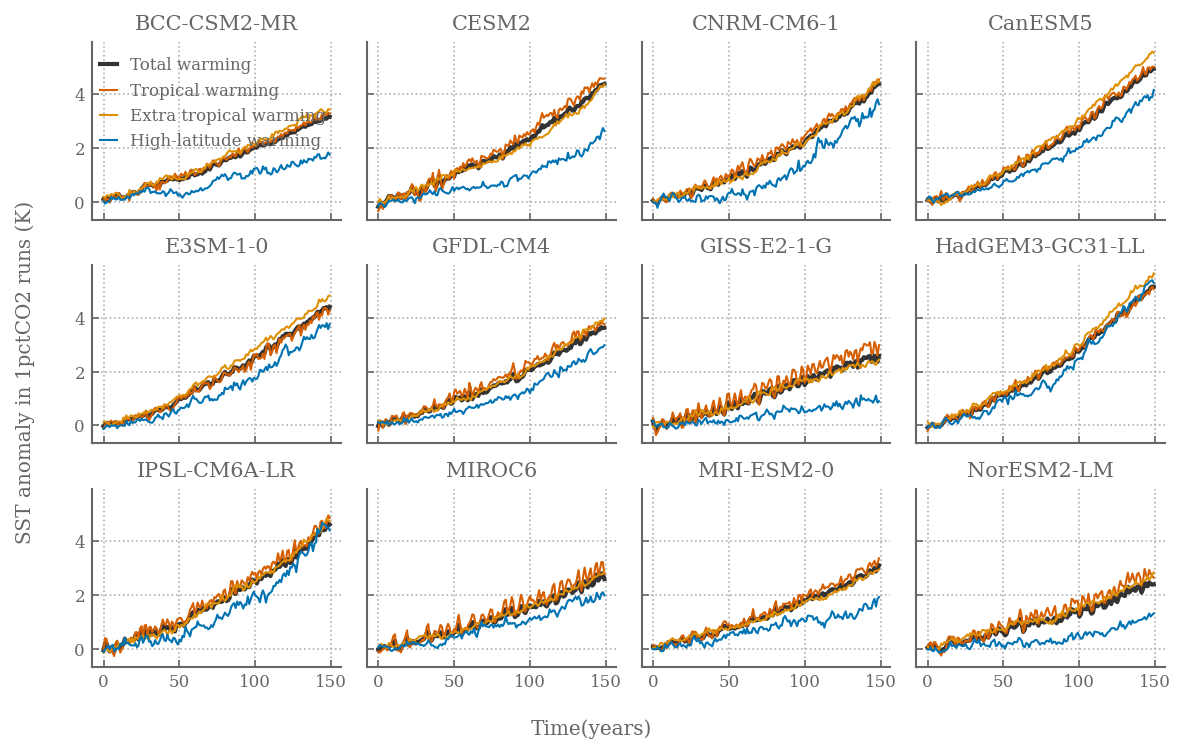

In [5]:
fig, axs = plt.subplots(3,4, figsize=(8,5), sharex=True, sharey=True)

for k, ax in enumerate(axs.flatten()):
    total.isel(model=k).plot(ax=ax, color='.2', lw=2, label = 'Total warming')
    tropics.isel(model=k).plot(ax=ax, color='C3', label = 'Tropical warming')
    midlat.isel(model=k).plot(ax=ax, color='C1', label = 'Extra tropical warming')
    highlat.isel(model=k).plot(ax=ax, color='C0', label = 'High-latitude warming')
    ax.set_title(ds.isel(model=k).model.values)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid()
axs[0,0].legend()
fig.supylabel('SST anomaly in 1pctCO2 runs (K)')
fig.supxlabel('Time(years)')
plt.tight_layout()
    

In [5]:
ds_sstClim = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/dF_sstClim.nc')
df_F = pd.concat([ds.f.sel(GF_source='mean').to_series(),ds.f.sel(GF_source='mean').to_series()*np.log(4)/np.log(1.01), ds_sstClim.dF.to_series()], axis=1)
df_F.columns = ['f','ERF_mean','sstClim']
df_F['sstClim_corrected'] = df_F.sstClim - (ds.lbd_u*ds_sstClim.dT).to_series()
# f = df_F.loc[ds.isel(model=k).model.values].sstClim_corrected

# df_F['f'] = ds.f.sel(GF_source='mean').to_series()
# df_F.loc[df_F.index!='NorESM2-LM'].corr()
# df_F.agg(['mean','std']).style.format(precision=3)

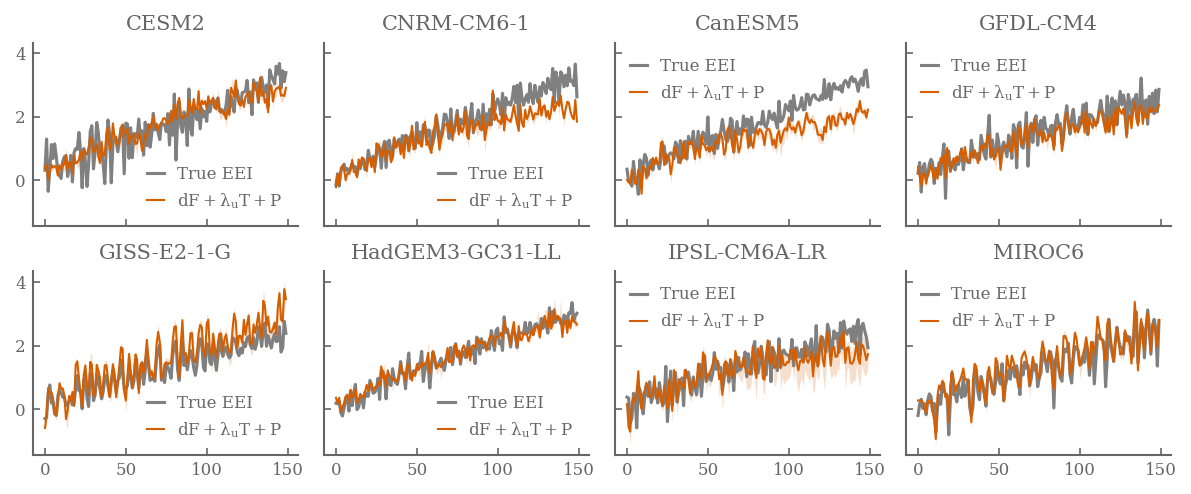

In [6]:
fig, axs = plt.subplots(2,4, figsize=(8,5*2/3), sharex=True, sharey=True)
all_delta = []
models = df_F.dropna().index
for k, ax in enumerate(axs.flatten()):
    ds.sel(model=models[k]).eei.plot(ax=ax, color='.5', lw=1.5, label='True EEI')
    f = df_F.loc[models[k]].sstClim_corrected
    dF_reco = np.log(1.01)/np.log(4)*f*ds.time
    eei_reco = (ds.sel(model=models[k]).dR_reco+dF_reco)
    eei_reco.lntime.plot(ax=ax, label=r'$dF + \lambda_u T + P$', color='C3')
    all_delta.append(eei_reco -ds.sel(model=models[k]).eei )
    ax.set_title(models[k])
    ax.set_xlabel('')
plt.tight_layout()
    

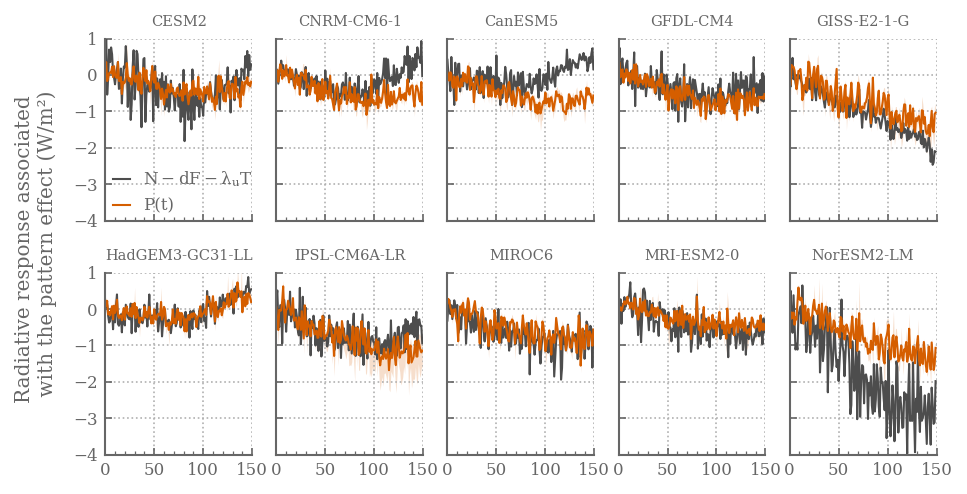

In [53]:
fig, axs = plt.subplots(2,5, figsize=(large_fig,5*2/3), sharex=True, sharey=True)
all_delta = []
models = df_F.dropna().index
for k, ax in enumerate(axs.flatten()):
    eei = ds.sel(model=models[k]).eei
    f = df_F.loc[models[k]].sstClim_corrected
    dRp_reco = eei - np.log(1.01)/np.log(4)*f*ds.time - ds.sel(model=models[k]).dRu
    dRp_reco.lntime.plot(ax=ax, label=r'$N - dF - \lambda_u T$', color='.3')
    ds.dRp_gf.sel(model=models[k]).lntime.plot(ax=ax, label = 'P(t)', add_legend=False, color='C3')
    all_delta.append(eei_reco -ds.sel(model=models[k]).eei )
    ax.set_title(models[k], size=7)
    ax.set_xlabel('')
    ax.legend().remove()
    ax.grid()
    ax.set_ylabel('')
    ax.set_ylim(-4,1)
    ax.set_xlim(0,150)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(10))
    ax.xaxis.set_major_locator(plt.MultipleLocator(50))

fig.supylabel('Radiative response associated\n with the pattern effect (W/m²)')
axs[0,0].legend(bbox_to_anchor=(-0.05,-0.05), loc ='lower left')
plt.tight_layout(w_pad=0)
plt.savefig('plots/comparing_pattern_effect_from_residuals_or_from_greens_functions.png', dpi=300)
    

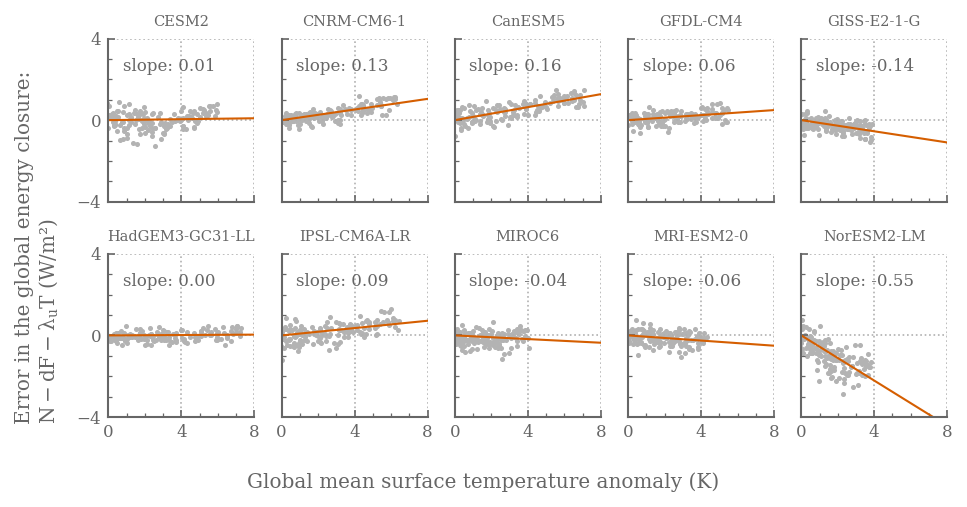

In [105]:
fig, axs = plt.subplots(2,5, figsize=(large_fig,5*2/3), sharex=True, sharey=True)
all_delta = []
models = df_F.dropna().index
for k, ax in enumerate(axs.flatten()):
    eei = ds.sel(model=models[k]).eei
    tas = ds.sel(model=models[k]).tas
    f = df_F.loc[models[k]].sstClim_corrected
    dRp_reco = eei - np.log(1.01)/np.log(4)*f*ds.time - ds.sel(model=models[k]).dRu
    dRp_gf = ds.dRp_gf.sel(model=models[k])#.lntime.plot(ax=ax, label = 'P(t)', add_legend=False, color='C3')
    x = tas 
    y = (-dRp_gf+dRp_reco).mean('GF_source')
    fit = curve_fit(lambda x,a : a*x, x, y)[0][0]
    ax.scatter(x,y, s=2, color='.7')
    ax.axline((0,0), slope=fit, color='C3', ls='-', lw=1)
    ax.text(0.1,0.8, f"slope: {fit:.02f}", transform=ax.transAxes)
    ax.set_title(models[k], size=7)
    ax.set_xlabel('')
    ax.grid()
    ax.set_ylabel('')
    ax.set_ylim(-4,4)
    ax.set_xlim(0,8)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(4))

fig.supylabel('Error in the global energy closure:\n'+r'$N - dF - \lambda_u T$ (W/m²)')
fig.supxlabel('Global mean surface temperature anomaly (K)')
# axs[0,0].legend(bbox_to_anchor=(-0.05,-0.05), loc ='lower left')
plt.tight_layout(w_pad=1)
plt.savefig('plots/residuals_from_global_energy_budget_plotted_against_tas_for_mean_greens_function.png', dpi=300)

In [67]:
dRp_gf

<xarray.DataArray 'dRp_gf' (GF_source: 4, time: 150)>
array([[ 0.13281 ,  0.361371, -0.264932, ..., -0.026783, -0.12241 , -0.003418],
       [ 0.16068 ,  0.297898, -0.174424, ..., -0.208884, -0.364066, -0.181224],
       [ 0.283261,  0.364786, -0.04826 , ..., -0.443274, -0.350368, -0.392754],
       [ 0.192251,  0.341352, -0.162539, ..., -0.226314, -0.278948, -0.192465]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 142 143 144 145 146 147 148 149
    model      <U5 'CESM2'
  * GF_source  (GF_source) object 'dong' 'zhang' 'zhou' 'mean'
    height     float64 2.0
    degree     int64 1
    Cs         (GF_source) float64 ...
    Cd         (GF_source) float64 ...
    gamma      (GF_source) float64 ...

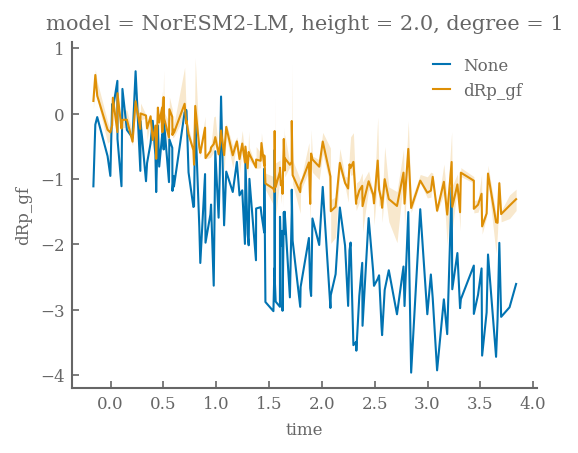

In [62]:
(dRp_reco).assign_coords(time=tas).sortby('time').lntime.plot()
(dRp_gf).assign_coords(time=tas).sortby('time').lntime.plot()

In [49]:
ds.tas.sel(time=slice(100,120)).mean('time')

<xarray.DataArray 'tas' (model: 12)>
array([3.23582545, 3.84198319, 4.04680124, 4.77029184, 5.38305821,
       3.66022714, 2.78788102, 4.7978427 , 3.98891173, 2.58730765,
       2.84932669, 2.39392379])
Coordinates:
  * model    (model) object 'BCC-CSM2-MR' 'CESM2' ... 'MRI-ESM2-0' 'NorESM2-LM'
    height   float64 2.0
    degree   int64 1

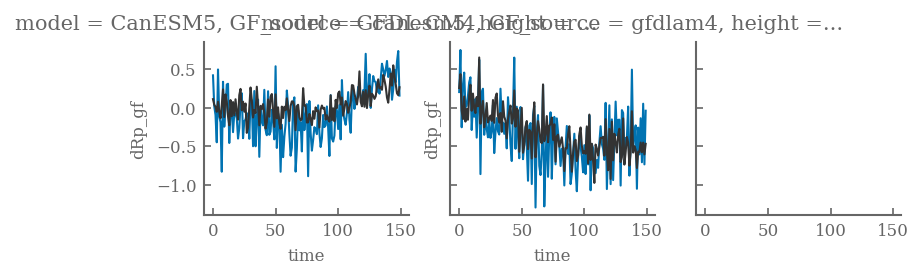

In [36]:
fig, axs = plt.subplots(1,3, figsize=(6,1.5), sharex=True, sharey=True)

model = 'CanESM5'
eei = ds.sel(model=model).eei
f = df_F.loc[model].sstClim_corrected
dRp_reco = eei - np.log(1.01)/np.log(4)*f*ds.time - ds.sel(model=model).dRu

dRp_reco.plot(ax=axs[0])
ds.dRp_gf.sel(model=model, GF_source='canesm5').plot(ax=axs[0], label = 'P(t)', hue='GF_source', add_legend=False, color='.2')

model = 'GFDL-CM4'
eei = ds.sel(model=model).eei
f = df_F.loc[model].sstClim_corrected
dRp_reco = eei - np.log(1.01)/np.log(4)*f*ds.time - ds.sel(model=model).dRu

dRp_reco.plot(ax=axs[1])
ds.dRp_gf.sel(model=model, GF_source='gfdlam4').plot(ax=axs[1], label = 'P(t)', hue='GF_source', add_legend=False, color='.2')

In [34]:
ds.dRp_gf.sel(model=model, GF_source='canesm5').plot(ax=ax, label = 'P(t)', hue='GF_source', add_legend=False, color='.2')

In [32]:
ds.dRp_gf

<xarray.DataArray 'dRp_gf' (GF_source: 7, model: 12, time: 150)> Size: 101kB
[12600 values with dtype=float64]
Coordinates:
  * time       (time) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
  * model      (model) <U15 720B 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-LM'
  * GF_source  (GF_source) <U7 196B 'cam5' 'gfdlam4' ... 'canesm5' 'mean'
    height     float64 8B 2.0
    degree     int64 8B 1
    Cs         (GF_source, model) float64 672B ...
    Cd         (GF_source, model) float64 672B ...
    gamma      (GF_source, model) float64 672B ...

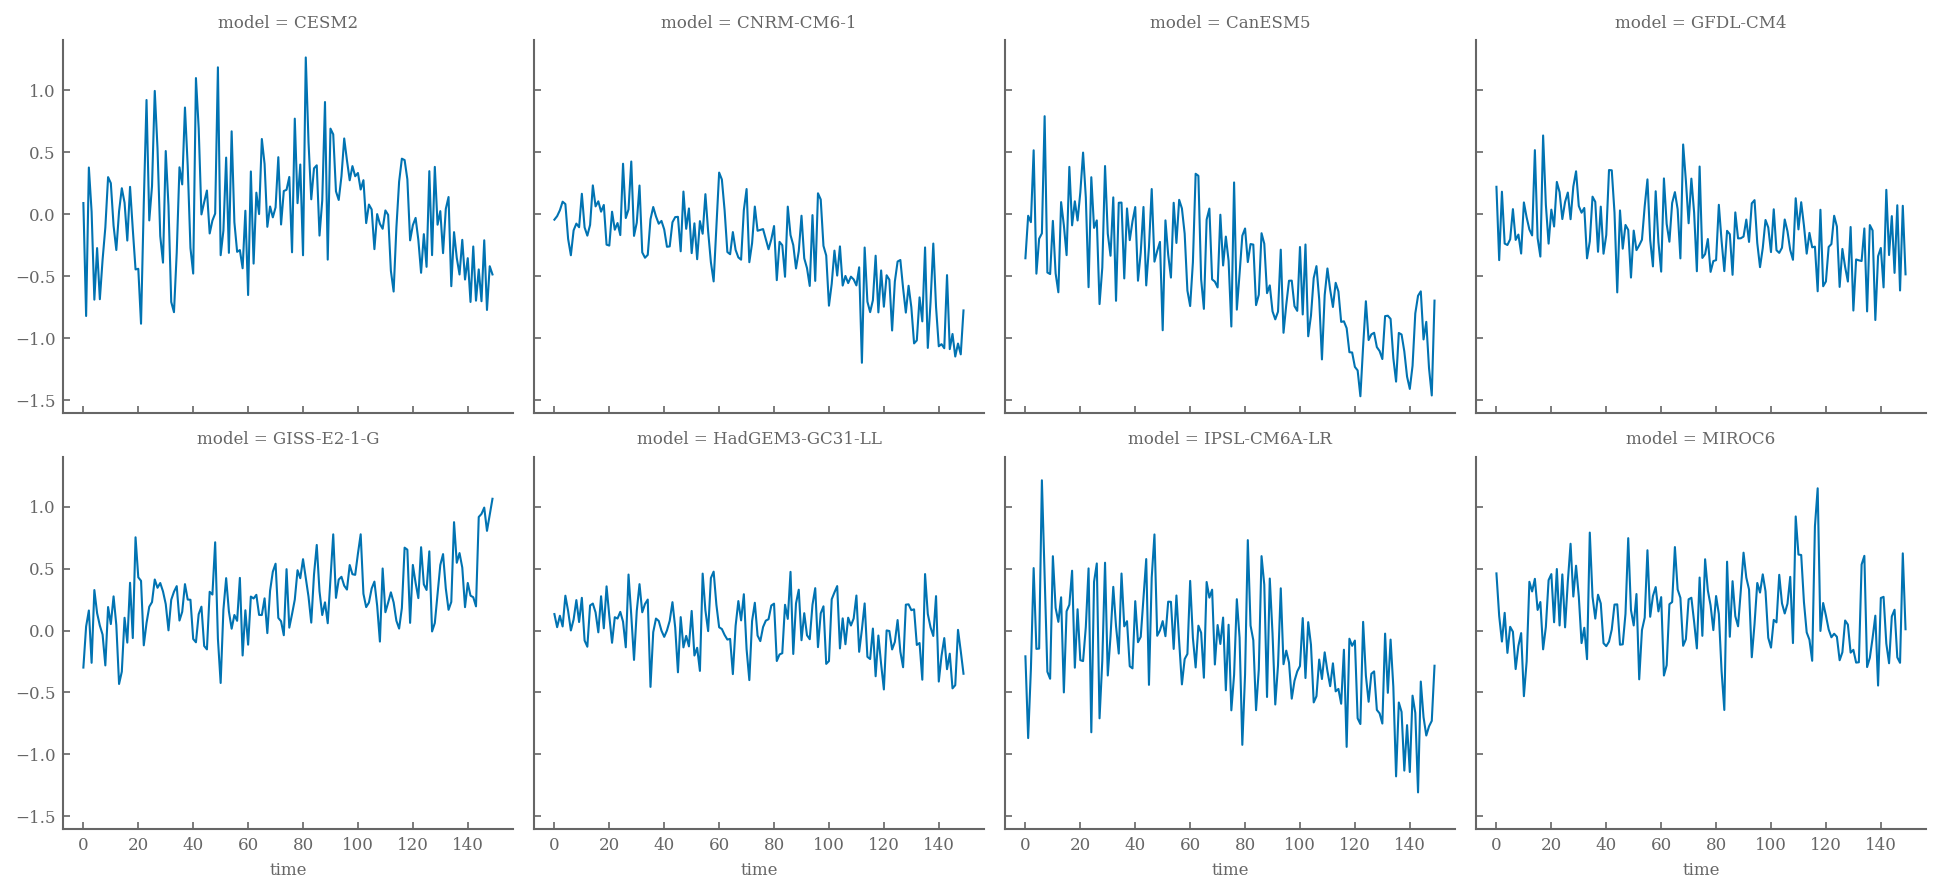

In [79]:
xr.concat(all_delta, dim='model').mean('GF_source').plot(col='model', col_wrap=4)

In [70]:
xr.open_dataset('/home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR/gf_dong.nc')

<xarray.Dataset> Size: 555kB
Dimensions:  (lat: 96, lon: 144)
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    TOA      (lat, lon) float64 111kB ...
    CRE      (lat, lon) float64 111kB ...
    CRELW    (lat, lon) float64 111kB ...
    CRESW    (lat, lon) float64 111kB ...
    TAS      (lat, lon) float64 111kB ...
Attributes:
    description:  CAM4 Greens function
    history:      Created Thu Aug 22 12:31:49 2019
    source:       Dong Y, C Proistosescu, KC Armour and DS Battisti (2019)   ...

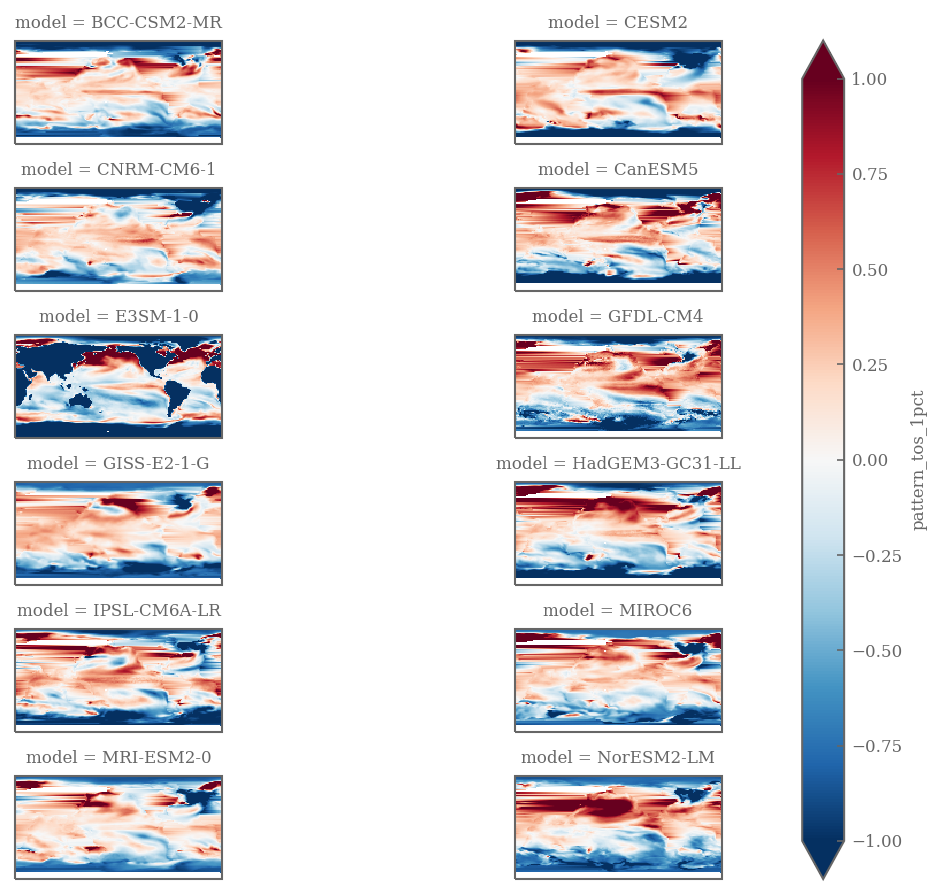

In [7]:
plot = ds.sel(lat=slice(-90,90)).pattern_tos_1pct.sel(time=slice(50,70)).mean('time').interpolate_na('lon')\
                                                            .plot(col='model', col_wrap=2, 
                                                             transform = ccrs.PlateCarree(),
                                                             subplot_kws=dict(projection=ccrs.PlateCarree(200)),
                                                             aspect=5, size=1, 
                                                             vmin=-1)

# for ax in plot.axs.flatten():
#     ax.add_feature(cfeat.LAND, zorder=10, edgecolor='.5')



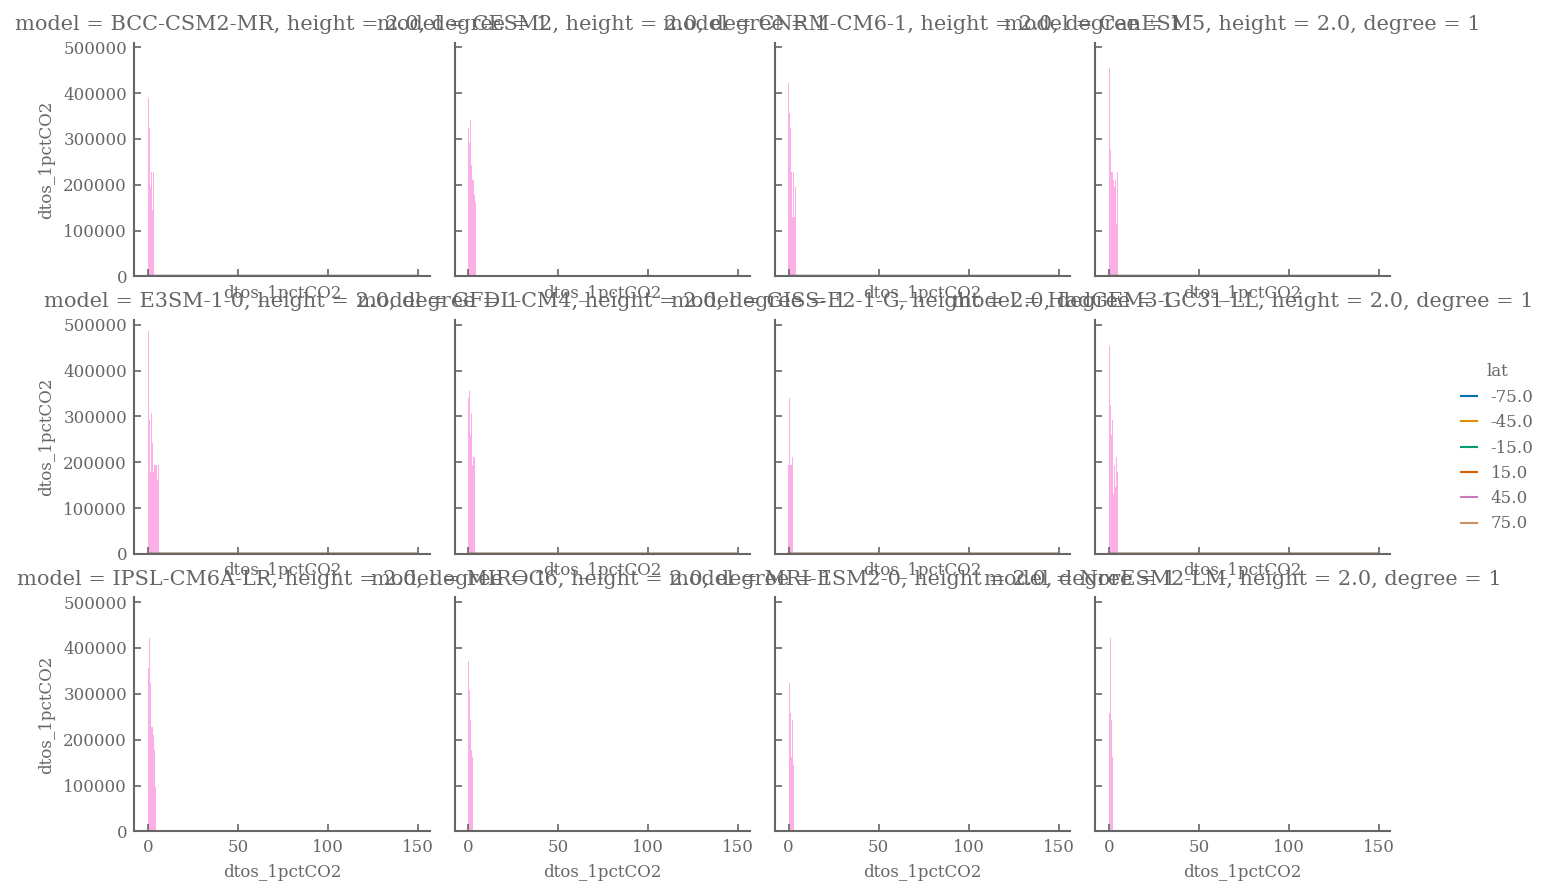

In [128]:
plot = ds.dtos_1pctCO2_grid.coarsen(lat=15).mean().mean('lon').plot(hue='lat', col='model', col_wrap=4,
                                                                    size=2)

for k, ax in enumerate(plot.axs.flatten()):
    ds.isel(model=k).weighted(np.cos(np.deg2rad(ds.lat))).mean(['lon','lat']).plot(ax=ax)

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        4.000e+00, 5.000e+00, 7.000e+00, 8.000e+00, 1.100e+01, 1.300e+01,
        6.000e+00, 9.000e+00, 1.200e+01, 1.500e+01, 1.400e+01, 1.200e+01,
        1.400e+01, 1.800e+01, 1.800e+01, 1.100e+01, 1.900e+01, 1.400e+01,
        1.800e+01, 3.400e+01, 4.700e+01, 5.800e+01, 5.300e+01, 4.500e+01,
        5.300e+01, 6.600e+01, 1.180e+02, 1.100e+02, 1.560e+02, 2.080e+02,
        2.660e+02, 3.140e+02, 4.350e+02, 6.400e+02, 8.980e+02, 6.349e+03,
        8.920e+02, 7.370e+02, 6.630e+02, 6.330e+02, 4.800e+02, 4.010e+02,
        3.120e+02, 2.710e+02, 2.260e+02, 1.820e+02, 1.480e+02, 1.170e+02,
        1.060e+02, 8.100e+01, 6.100e+01, 5.900e+01, 4.700e+01, 4.300e+01,
        3.600e+01, 3.500e+01, 2.300e+01, 8.000e+00, 1.400e+01, 7.000e+00,
        9.000e+00, 8.000e+00, 5.000e+00, 4.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 3.000e+00, 6.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 4.000e+00, 0.000e+0

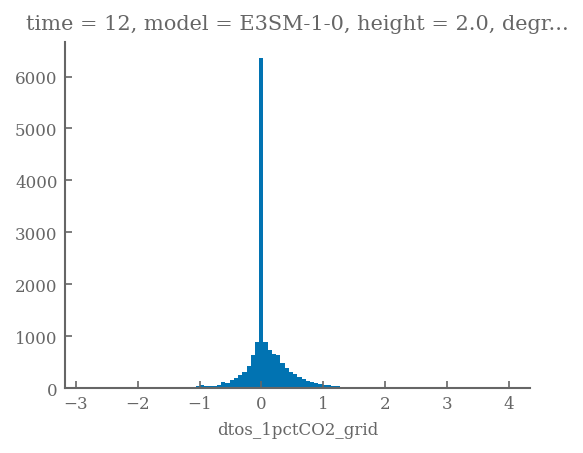

In [142]:
ds.dtos_1pctCO2_grid.sel(model='E3SM-1-0').sel(time=12).plot.hist(bins=100)

In [117]:
45/9

5.0